In [1]:
!pip install nltk

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pal = sns.color_palette()
from wordcloud import WordCloud, STOPWORDS

#text preprocessing
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words("english"))
import string
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import hstack, csr_matrix

In [3]:

# Load dataset
url = "https://raw.githubusercontent.com/GuviMentor88/Training-Datasets/refs/heads/main/twitter_training.csv"
df_train = pd.read_csv(url, header=None, names=["Tweet ID", "Entity", "Sentiment", "Tweet Content"])
df_train.head()

Tweet ID       Entity Sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   

                                       Tweet Content  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...

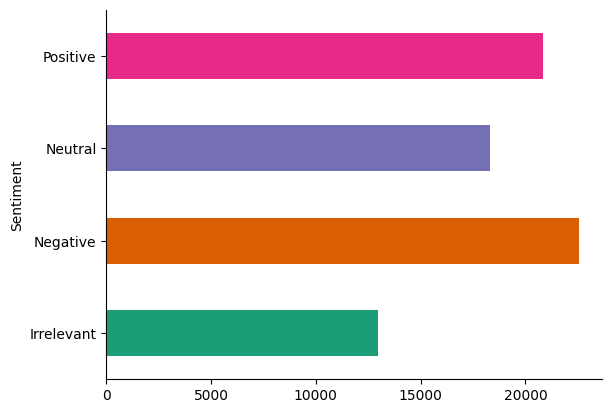

In [4]:

# @title Sentiment

from matplotlib import pyplot as plt
import seaborn as sns
df_train.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [5]:

df_train["Entity"].unique()

array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

In [6]:
df_train["Sentiment"].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [7]:
# Combine 'Irrelevant' into 'Neutral'
df_train['Sentiment'] = df_train['Sentiment'].replace('Irrelevant', 'Neutral')

# Verify the changes
print(df_train['Sentiment'].unique())
df_train.head()

['Positive' 'Neutral' 'Negative']


Tweet ID       Entity Sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   

                                       Tweet Content  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...

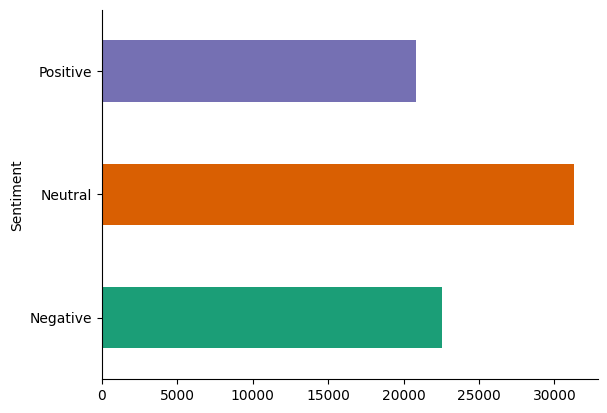

In [8]:

# @title Sentiment

from matplotlib import pyplot as plt
import seaborn as sns
df_train.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [9]:
df_train.columns = df_train.columns.str.strip()

In [10]:
# Print the first few rows and column names
print(df_train.head())
print(df_train.columns)

# Check for columns containing 'Sentiment'
print([col for col in df_train.columns if 'Sentiment' in col])

   Tweet ID       Entity Sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   

                                       Tweet Content  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  
Index(['Tweet ID', 'Entity', 'Sentiment', 'Tweet Content'], dtype='object')
['Sentiment']


In [11]:

# Count the occurrences of each sentiment class
sentiment_counts = df_train['Sentiment'].value_counts()

# Display the counts
print(sentiment_counts)

Sentiment
Neutral     31308
Negative    22542
Positive    20832
Name: count, dtype: int64


In [12]:
print(df_train['Sentiment'].isnull().sum())

0


In [13]:
df_train.shape

(74682, 4)

In [14]:

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet ID       74682 non-null  int64 
 1   Entity         74682 non-null  object
 2   Sentiment      74682 non-null  object
 3   Tweet Content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [15]:

df_train.isnull().sum().sum()

686

In [16]:
# Check the count of null values
print(f"Before removal: {df_train.shape}")
print(df_train["Tweet Content"].isnull().sum())

# Remove rows with null 'Tweet Content'
df_train = df_train.dropna(subset=["Tweet Content"])

# Verify the removal
print(f"After removal: {df_train.shape}")
print(df_train["Tweet Content"].isnull().sum())

Before removal: (74682, 4)
686
After removal: (73996, 4)
0


In [17]:
df_train.isnull().sum().sum()

0

In [18]:
# Preprocessing
df_train = df_train[["Tweet Content", "Sentiment"]]
df_train = df_train.rename(columns={"Tweet Content": "text", "Sentiment": "label"})

# Encode labels
label_mapping = {"Positive": 2, "Negative": 0, "Neutral": 1}
df_train['label'] = df_train['label'].map(label_mapping)

In [19]:
df_train.head()

text  label
0  im getting on borderlands and i will murder yo...      2
1  I am coming to the borders and I will kill you...      2
2  im getting on borderlands and i will kill you ...      2
3  im coming on borderlands and i will murder you...      2
4  im getting on borderlands 2 and i will murder ...      2

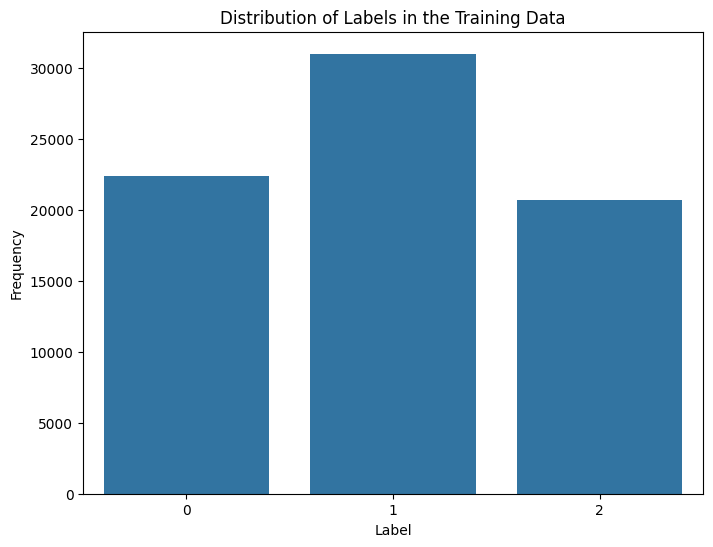

In [20]:
# prompt: Using dataframe df_train: suggest a plot

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the frequency of each label
label_counts = df_train['label'].value_counts()

# Create a bar plot of the label frequencies
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in the Training Data')
plt.show()

In [21]:
df_train.shape

(73996, 2)

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73996 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    73996 non-null  object
 1   label   73996 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [23]:
df_train.isnull().sum()

text     0
label    0
dtype: int64

In [24]:

df_train.dropna(inplace=True)

In [25]:
df_train.isnull().sum()

text     0
label    0
dtype: int64

In [26]:
df_train.shape

(73996, 2)

In [27]:
df_train["label"] = df_train["label"].astype(int)

In [28]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73996 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    73996 non-null  object
 1   label   73996 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


(-0.5, 1439.5, 1079.5, -0.5)

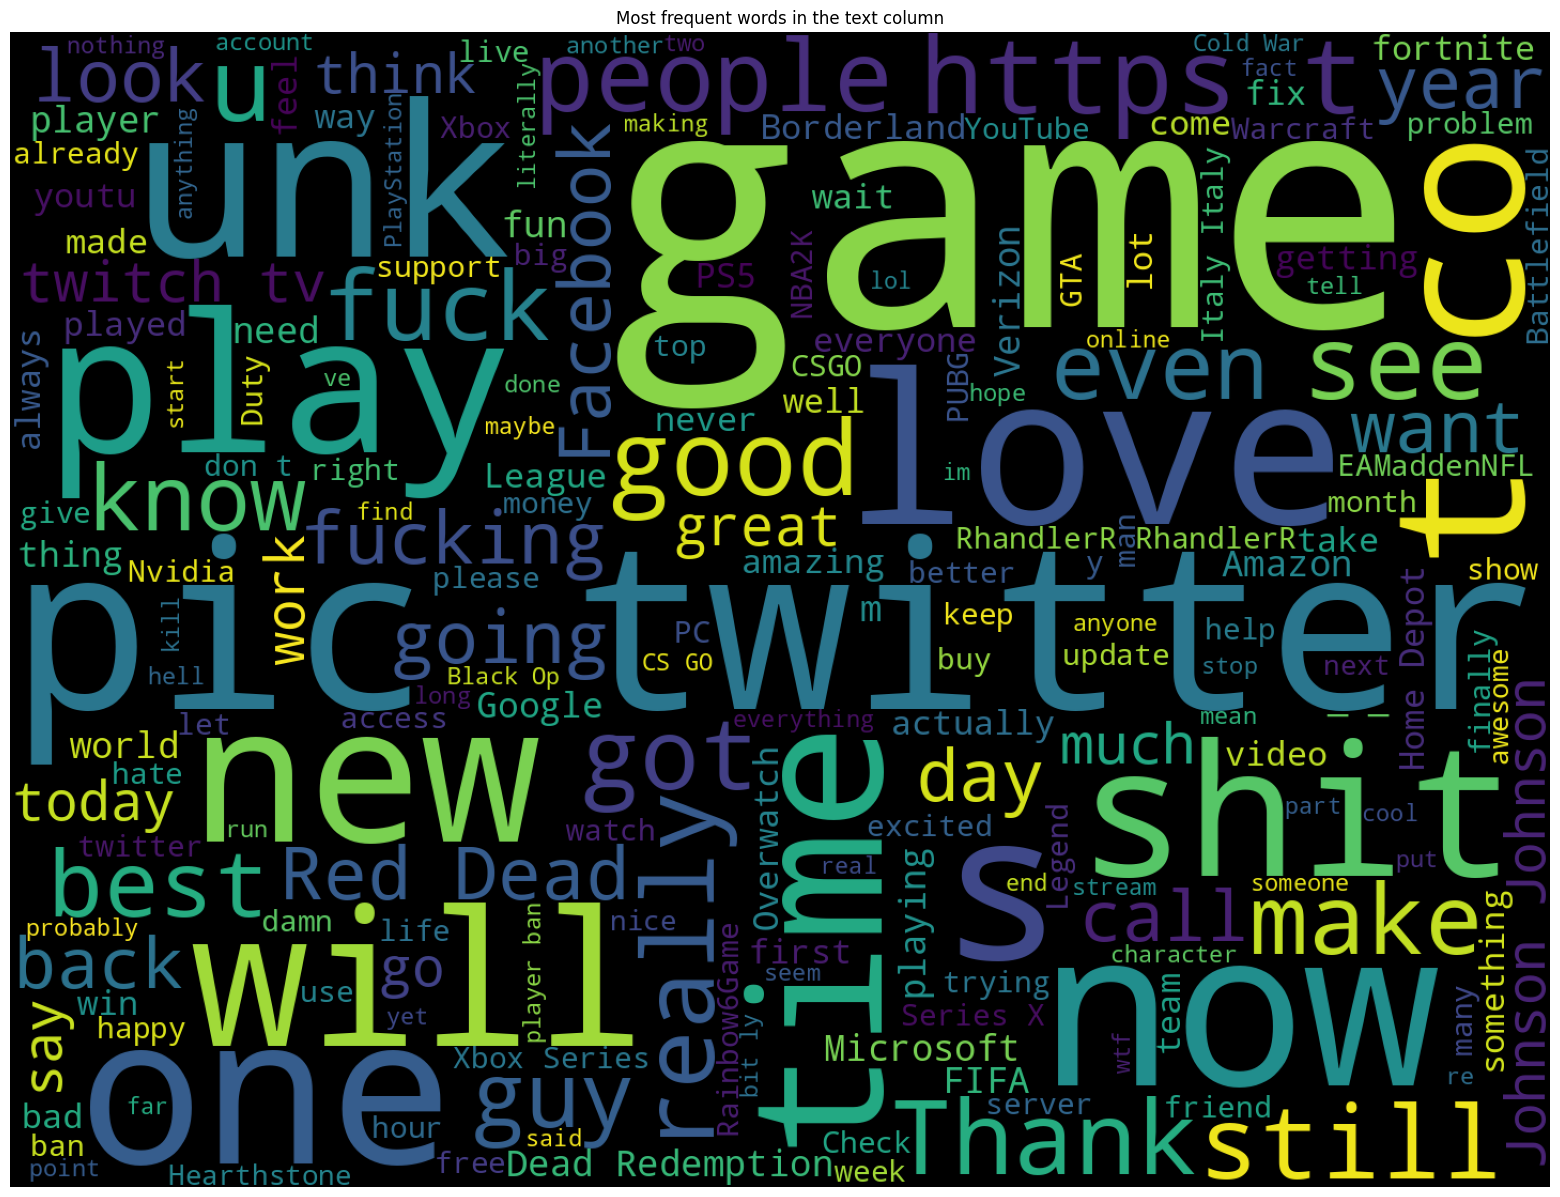

In [29]:
train_desc = pd.Series(df_train['text'].tolist()).astype(str)
cloud = WordCloud(width=1440, height=1080,stopwords=STOPWORDS).generate(" ".join(train_desc.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.title("Most frequent words in the text column")
plt.axis('off')

In [30]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

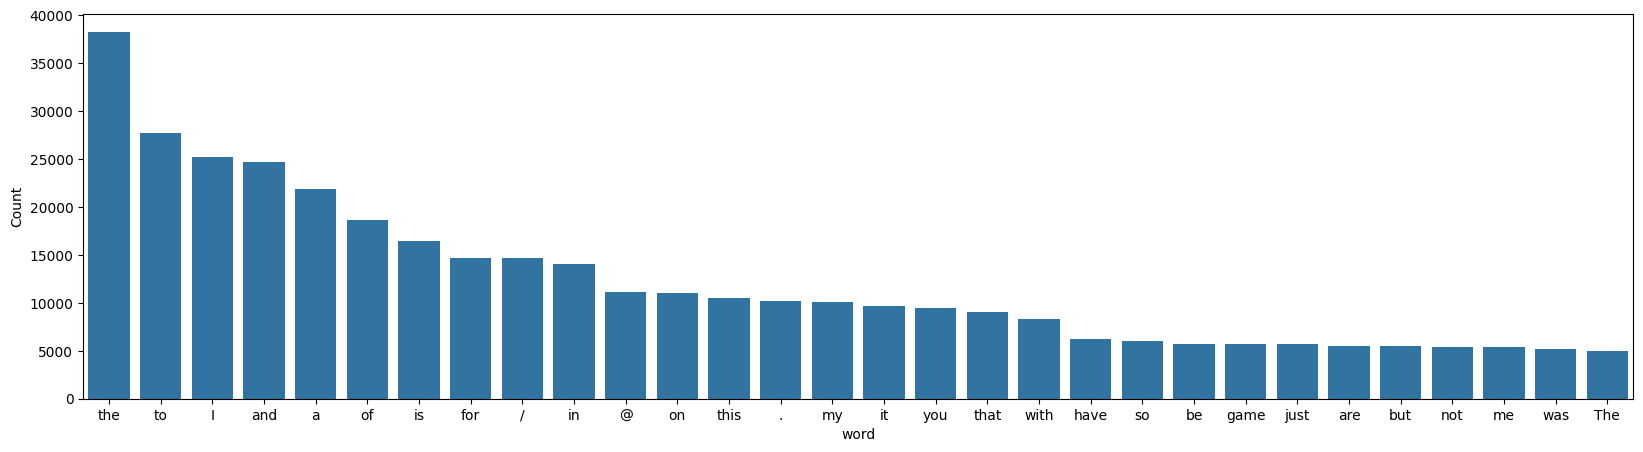

In [31]:
import nltk
from nltk import FreqDist
freq_words(df_train['text'])

In [32]:
# remove unwanted characters, numbers and symbols
df_train['text'] = df_train['text'].str.replace("[^a-zA-Z#]", " ")

In [33]:
#Let’s try to remove the stopwords and short words (<2 letters) from the reviews.
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [34]:
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
sentiment = [remove_stopwords(r.split()) for r in df_train['text']]

# make entire text lowercase
sentiment = [r.lower() for r in sentiment]

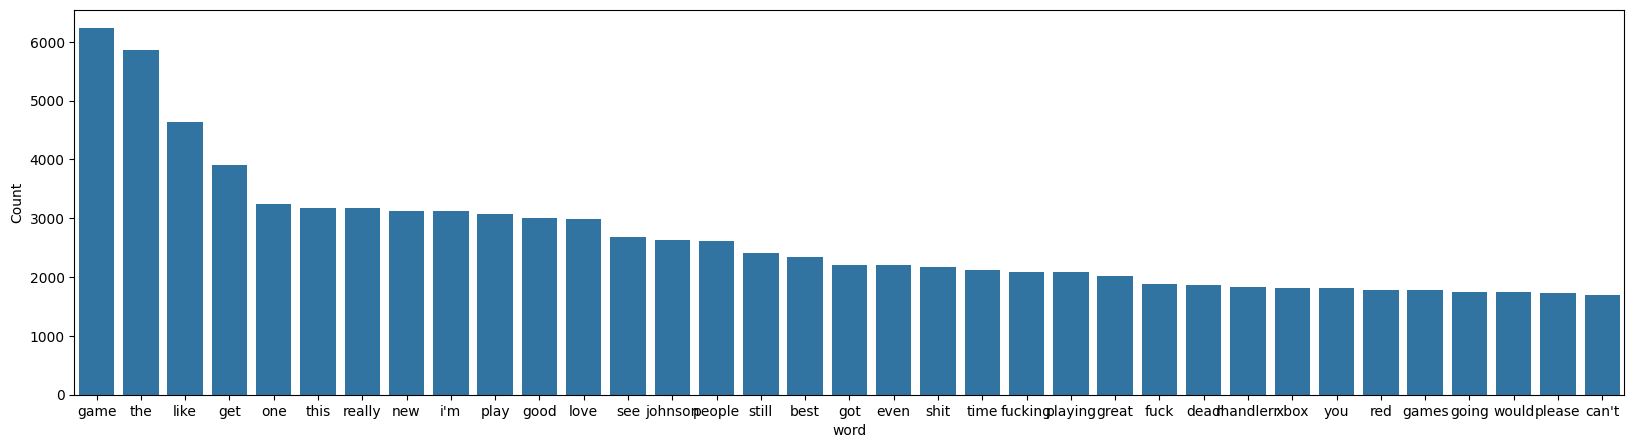

In [35]:
#Let’s again plot the most frequent words and see if the more significant words have come out.

freq_words(sentiment, 35)

In [36]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent))
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

In [37]:
#Let’s tokenize the sentiment and then lemmatize the tokenized sentiment.

tokenized_sentiment = pd.Series(sentiment).apply(lambda x: x.split())
print(tokenized_sentiment[1])

['coming', 'borders', 'kill', 'all,']


In [38]:
sentiment_2 = lemmatization(tokenized_sentiment)
print(sentiment_2[1]) # print lemmatized review

['border']


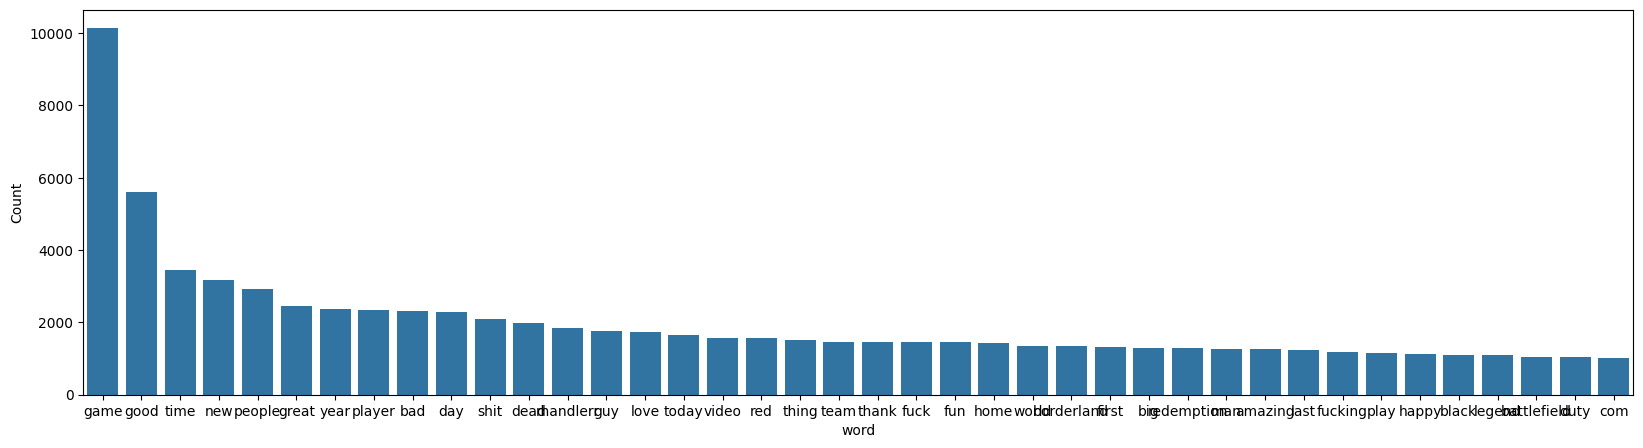

In [39]:
#As you can see, we have not just lemmatized the words but also filtered only nouns and adjectives. Let’s de-tokenize the lemmatized sentiment and plot the most common words.

sentiment_3 = []
for i in range(len(sentiment_2)):
    sentiment_3.append(' '.join(sentiment_2[i]))

df_train['text'] = sentiment_3

freq_words(df_train['text'], 40)

(-0.5, 1439.5, 1079.5, -0.5)

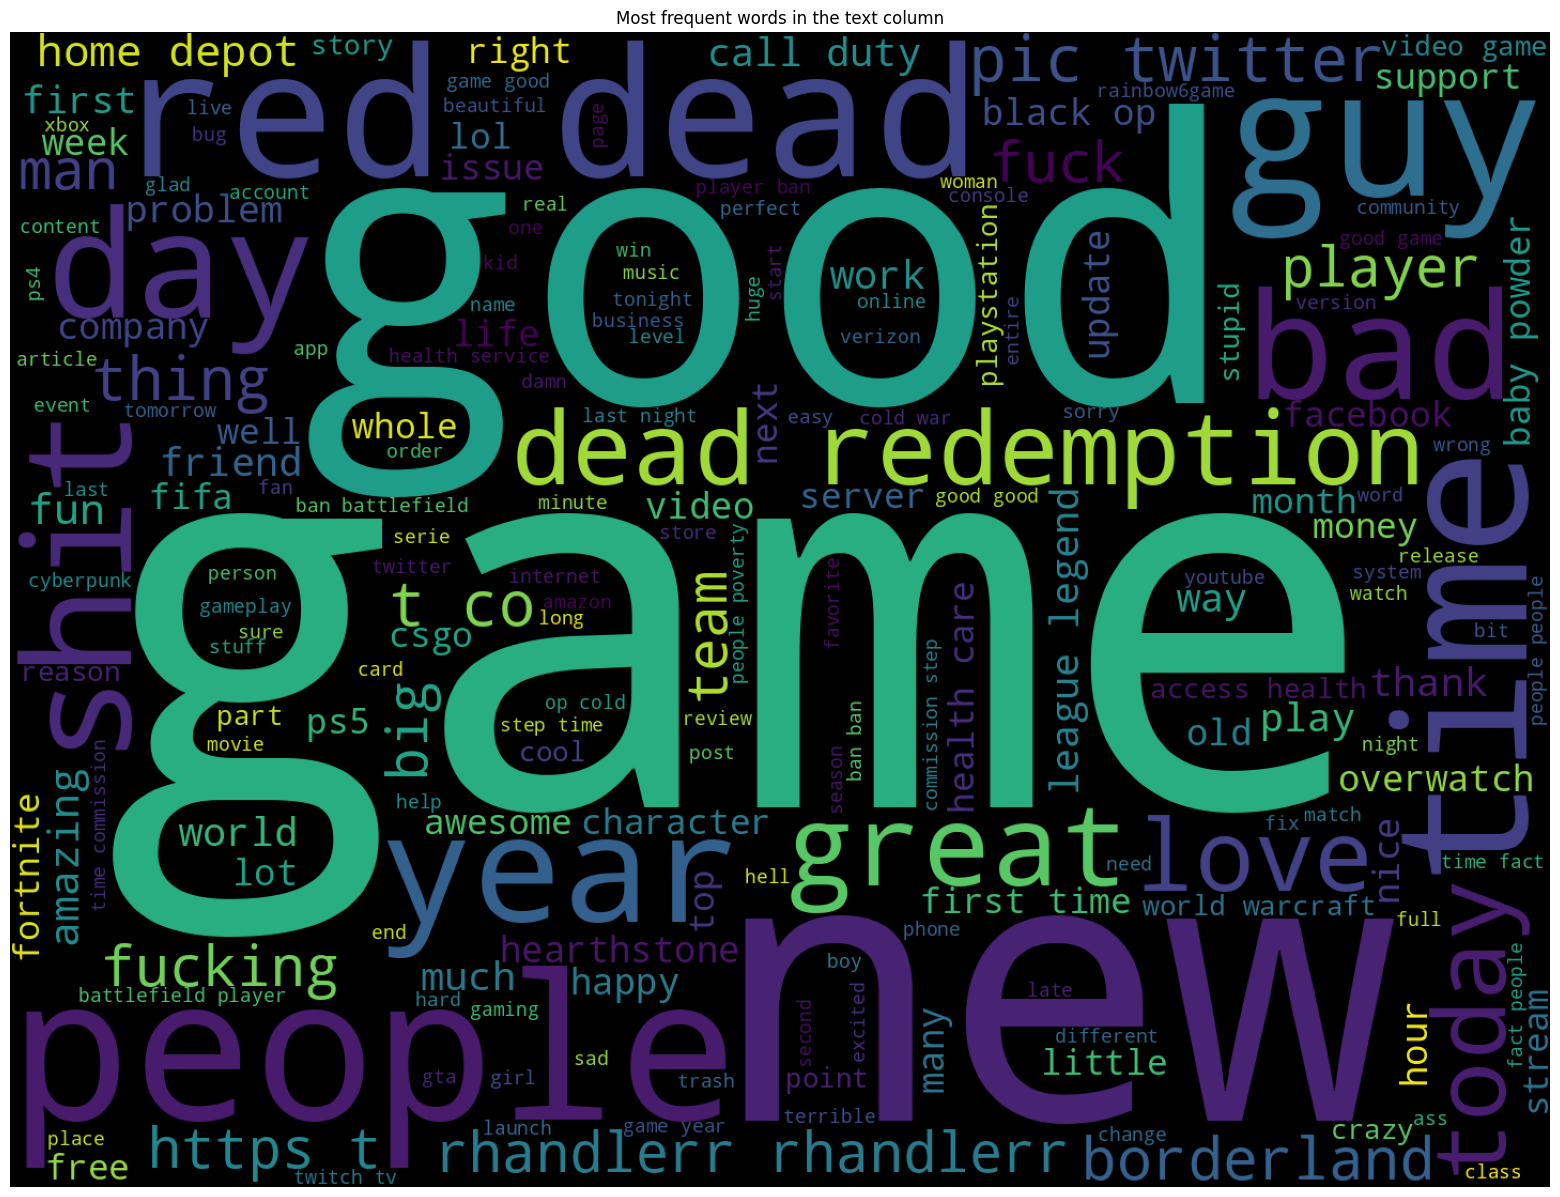

In [40]:
train_desc = pd.Series(df_train['text'].tolist()).astype(str)
cloud = WordCloud(width=1440, height=1080,stopwords=STOPWORDS).generate(" ".join(train_desc.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.title("Most frequent words in the text column")
plt.axis('off')

In [41]:

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [42]:
df_train['text'] = df_train['text'].apply(remove_urls)
df_train.head()

text  label
0         borderland      2
1             border      2
2         borderland      2
3  borderland murder      2
4         borderland      2

(-0.5, 1439.5, 1079.5, -0.5)

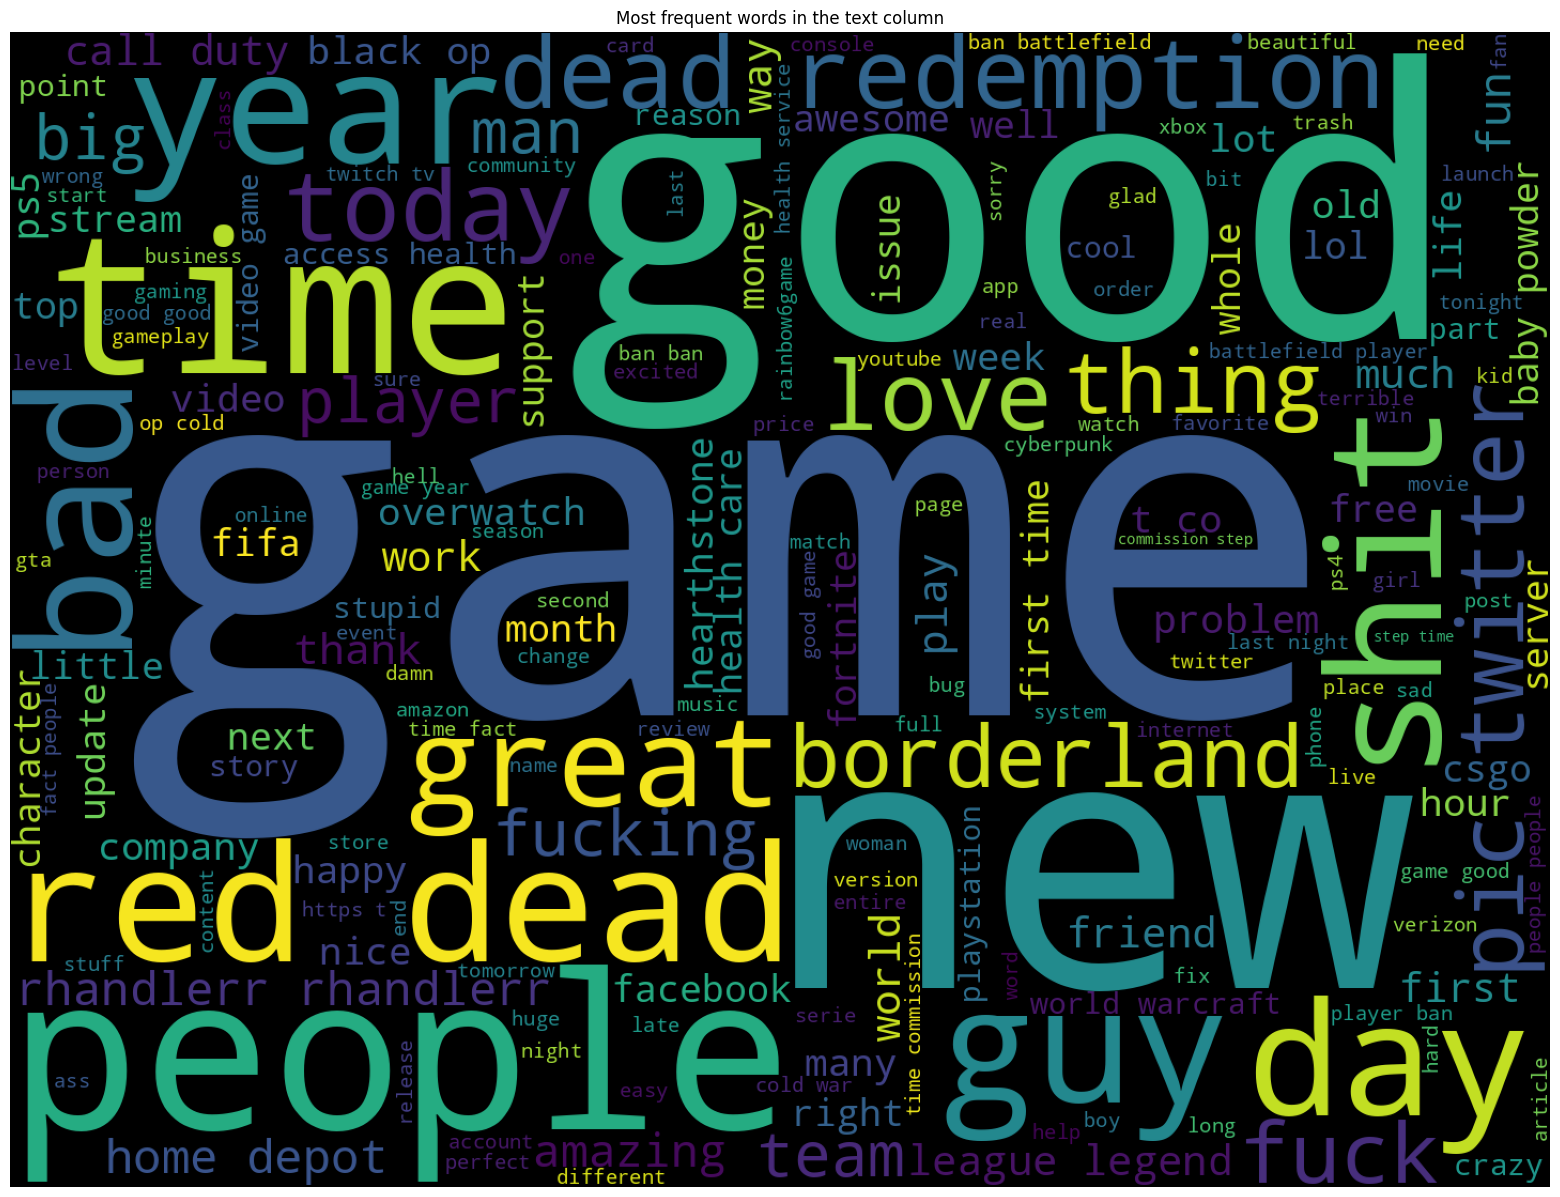

In [43]:
train_desc = pd.Series(df_train['text'].tolist()).astype(str)
cloud = WordCloud(width=1440, height=1080,stopwords=STOPWORDS).generate(" ".join(train_desc.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.title("Most frequent words in the text column")
plt.axis('off')

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
df_train.to_csv('/content/drive/MyDrive/sentiment_analysis_1.csv', index=False)

In [47]:
df_train.isnull().sum()

text     0
label    0
dtype: int64

In [48]:
# Check how many rows have an empty list in the 'text' column
empty_list_count = df_train[df_train['text'].apply(lambda x: x == [])].shape[0]
print(f"Number of rows with empty lists: {empty_list_count}")

Number of rows with empty lists: 0


In [49]:
# Remove rows where 'text' column contains an empty list
df_train = df_train[df_train['text'].apply(lambda x: x != [])]

# Verify the change
print(df_train.shape)

(73996, 2)


In [50]:
print(df_train['text'].apply(lambda x: x == []).sum())  # Should print 0

0


In [51]:
df_train.to_csv('/content/drive/MyDrive/sentiment_analysis_1.csv', index=False)

Distillbert Sentiment Analysis

In [52]:
# Install necessary libraries
!pip install transformers datasets torch scikit-learn

# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/sentiment_analysis_1.csv')
print(df.head())
df['text'] = df['text'].astype(str)

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42
)

# Tokenize the data
# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
# val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)

# Create a PyTorch Dataset
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, list(train_labels))
val_dataset = SentimentDataset(val_encodings, list(val_labels))

# Load the model and move to CPU
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3  # Assuming 3 sentiment classes: Negative, Neutral, Positive
)

# Import necessary libraries
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments

# Define training arguments with GPU and increased batch size
training_args = TrainingArguments(
    output_dir="./results",            # Directory to save model checkpoints
    num_train_epochs= 5,               # Max number of epochs
    per_device_train_batch_size=32,    # Batch size for training
    per_device_eval_batch_size=64,     # Batch size for evaluation
    warmup_steps=500,                  # Warmup steps for learning rate scheduler
    weight_decay=0.01,                 # Weight decay for regularization
    logging_dir="./logs",              # Directory for logging
    evaluation_strategy="epoch",       # Evaluate at the end of each epoch
    save_strategy="epoch",             # Save model at the end of each epoch
    save_total_limit=2,                # Keep only the 2 latest checkpoints
    load_best_model_at_end=True,       # Load the best model at the end of training
    logging_steps=100,
    report_to="none",                  # Disable reporting for now
    fp16=True                          # Enable mixed precision for faster training on GPU
)

# Ensure the model and data are moved to GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU. Consider using a GPU for faster training.")

# Move the model to the selected device
model = model.to(device)

# Compute metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

# Define Trainer with EarlyStoppingCallback
trainer = Trainer(
    model=model,                       # The model
    args=training_args,                # Training arguments
    train_dataset=train_dataset,       # Training dataset
    eval_dataset=val_dataset,          # Validation dataset
    tokenizer=tokenizer,               # Tokenizer
    compute_metrics=compute_metrics,   # Metrics function
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Stop if no improvement after 2 epochs
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print("Validation results:", results)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Using GPU: Tesla T4


<ipython-input-52-08810ae21ae9>:93: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Validation results: {'eval_loss': 0.48521900177001953, 'eval_accuracy': 0.8109459459459459, 'eval_f1': 0.8122944045637674, 'eval_runtime': 12.8421, 'eval_samples_per_second': 1152.457, 'eval_steps_per_second': 18.066, 'epoch': 5.0}


In [53]:
# Stop training if you're done
trainer.save_model("/content/drive/MyDrive/Distilbert-base-uncased")  # Save model
tokenizer.save_pretrained("/content/drive/MyDrive/Distilbert-base-uncased")  # Save tokenizer

('/content/drive/MyDrive/Distilbert-base-uncased/tokenizer_config.json',
 '/content/drive/MyDrive/Distilbert-base-uncased/special_tokens_map.json',
 '/content/drive/MyDrive/Distilbert-base-uncased/vocab.txt',
 '/content/drive/MyDrive/Distilbert-base-uncased/added_tokens.json',
 '/content/drive/MyDrive/Distilbert-base-uncased/tokenizer.json')

In [54]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import torch.nn.functional as F

# Load fine-tuned model and tokenizer
model_path = "/content/drive/MyDrive/Distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)


In [55]:
def predict_sentiment(texts):
    # Tokenize input texts
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Apply softmax to get probabilities
    probs = F.softmax(outputs.logits, dim=-1)

    # Get class probabilities and format the output
    results = []
    for i, prob in enumerate(probs):
        result = {
            "Text": texts[i],
            "Probabilities": {
                "Negative": round(prob[0].item(), 4),
                "Neutral": round(prob[1].item(), 4),
                "Positive": round(prob[2].item(), 4),
            }
        }
        results.append(result)
    return results

In [56]:
texts = [
    "I love this product!",
    "This is the worst experience ever.",
    "guvi has the best data science road map in industry"
]

predictions = predict_sentiment(texts)

# Display results
for prediction in predictions:
    print(f"Text: {prediction['Text']}")
    for sentiment, prob in prediction["Probabilities"].items():
        print(f"  {sentiment}: {prob}")
    print()


Text: I love this product!
  Negative: 0.0359
  Neutral: 0.1745
  Positive: 0.7896

Text: This is the worst experience ever.
  Negative: 0.5479
  Neutral: 0.2609
  Positive: 0.1911

Text: guvi has the best data science road map in industry
  Negative: 0.0078
  Neutral: 0.6365
  Positive: 0.3557



In [1]:
!pip install gradio


In [2]:
#!pip install gradio flask

import gradio as gr
import torch
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from flask import request
import logging
from datetime import datetime

# Load fine-tuned model and tokenizer
model_path = "/content/drive/MyDrive/Distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Set up logging
logging.basicConfig(
    filename="user_logs.txt",  # Logs will be saved to this file
    level=logging.INFO,
    format="%(asctime)s - %(message)s",
)

def log_user_details(user_ip, input_text):
    log_message = f"IP: {user_ip} | Input: {input_text}"
    logging.info(log_message)
    print(log_message)  # Optional: Print logs for testing in Colab

def predict_sentiment(text):
    # Get user IP address (only works with Flask requests)
    user_ip = request.remote_addr if request else "Unknown IP"
    log_user_details(user_ip, text)

    # Predict sentiment
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=-1)
    # Get class probabilities and format the output
    result = {
        "Negative": round(probs[0][0].item(), 4),
        "Neutral": round(probs[0][1].item(), 4),
        "Positive": round(probs[0][2].item(), 4),
    }
    return result

iface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=2, placeholder="Enter text here..."),
    outputs=gr.JSON(),
    title="Sentiment Analysis",
    description="Enter some text and get the predicted sentiment probabilities."
)

iface.launch(share=True)  # `share=True` creates a public URL

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fc1503bd3d938e5aee.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [3]:
# Read the log file and print its content
log_file_path = "user_logs.txt"

try:
    with open(log_file_path, "r") as log_file:
        logs = log_file.readlines()
        print("User Logs:")
        for line in logs:
            print(line.strip())  # Remove extra newline characters
except FileNotFoundError:
    print(f"Log file '{log_file_path}' not found.")

Log file 'user_logs.txt' not found.
